<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pima-Indian-Diabetes-Dataset:-Binary-Class-Problem" data-toc-modified-id="Pima-Indian-Diabetes-Dataset:-Binary-Class-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pima Indian Diabetes Dataset: Binary Class Problem</a></span></li><li><span><a href="#Preparation" data-toc-modified-id="Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#K-Nearest-Neighbors" data-toc-modified-id="K-Nearest-Neighbors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>K Nearest Neighbors</a></span></li><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neural Network</a></span><ul class="toc-item"><li><span><a href="#Building" data-toc-modified-id="Building-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Building</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Metrics</a></span></li></ul></li><li><span><a href="#TASK" data-toc-modified-id="TASK-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TASK</a></span></li></ul></div>

# Pima Indian Diabetes Dataset: Binary Class Problem

https://www.kaggle.com/uciml/pima-indians-diabetes-database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

# Preparation

In [1]:
import time

import numpy as np 
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import model_to_dot

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import SVG

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(42)

# EDA

Read data

In [4]:
pima = pd.read_csv("pima-indians-diabetes.csv", delimiter="\t")

Let's observe the correlations between features and outcome

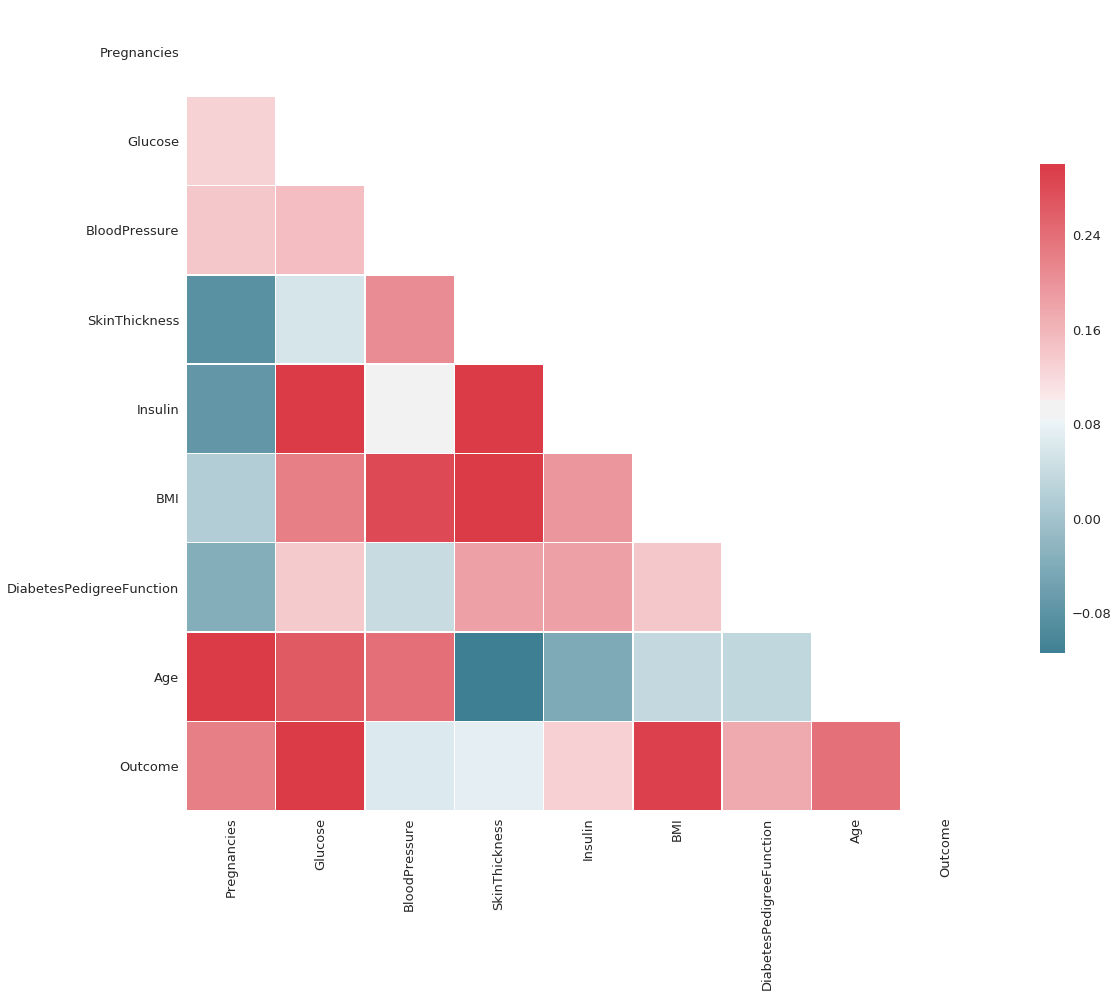

In [5]:
# compute the correlation matrix
corr = pima.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Statistics on data

In [6]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Create Training and testing split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pima.iloc[:, :8], pima.iloc[:, 8], test_size=0.30, random_state=42)

# K Nearest Neighbors

Let's do a little of Cross-Validation and find the optimal number of nearest neighbors for KNN.

For this purpose we're going to use `GridSearchCV` function from `scikit-learn`. It uses the notion of *cross-validation*: 

1. Split the given data into predefined number of folds.
2. Leave one fold for testing and use other for training. Repeat it for all folds.
3. Average the test score across the folds.
4. The average score is the estimation of the test quality.

One can easily adapt this technique for choosing the best set of parameters among some predefined set. Just calculate the CV score for each setting and then chose the one with the highest score

In [9]:
model = GridSearchCV(estimator=KNeighborsClassifier(), # the estimator we're going to evaluate
                     param_grid={"n_neighbors": np.arange(1, 21)}, # the parameters set
                     cv=5, # nubmer fo folds
                     refit=True) # fit model with the best params on the whole dataset
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
print("Best n_neighbors:", model.best_params_["n_neighbors"])
print("Estimated test accuracy: {0:.2f}%".format(model.best_score_ * 100))

Best n_neighbors: 10
Estimated test accuracy: 73.93%


Let's see how estimated test accuracy depends on the number of neighbors

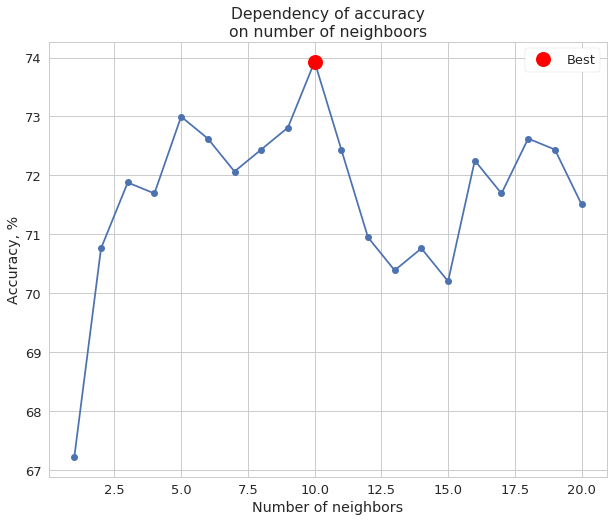

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(model.param_grid["n_neighbors"], 
         model.cv_results_["mean_test_score"] * 100, 
         "o-")
plt.plot([model.best_params_["n_neighbors"]], 
         [model.best_score_ * 100], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy, %")
plt.legend(numpoints=1)
plt.title("Dependency of accuracy\non number of neighboors");

Finally let's see how our estimator performs on the hold-out test set

In [12]:
y_pred = model.predict(X_test)
print("KNN Test Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred) * 100))

KNN Test Accuracy is 71.86


# Neural Network

Let's try fully-connected network with 8-8-32-16-1 architecture

Here we're going to use `Sequential` container for it (in previous notebooks we used Keras Model API)

## Building

In [13]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Compile the model

In [14]:
%time 
model.compile(loss='binary_crossentropy', 
              optimizer="adam", 
              metrics=['accuracy'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 905
Trainable params: 905
Non-trainable params: 0
_________________________________________________________________


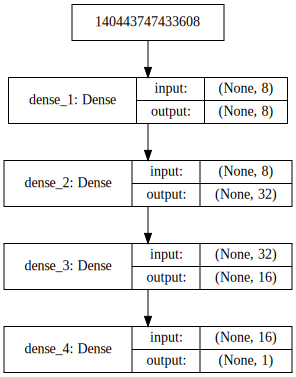

In [16]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [17]:
%%time

history = model.fit(X_train.values, y_train, 
                    validation_data=(X_test.values, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    verbose=0)

CPU times: user 3.42 s, sys: 560 ms, total: 3.98 s
Wall time: 2.88 s


History is the dictionary which stores the metrics during training

In [18]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

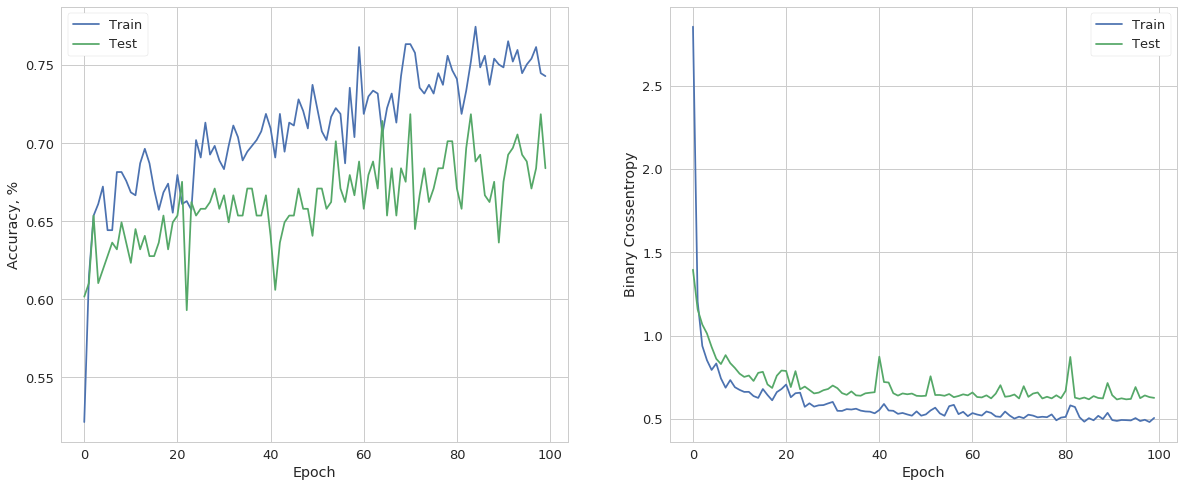

In [19]:
plt.figure(figsize=(20, 8))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history.history['acc'], label="Train")
plt.plot(history.history['val_acc'], label="Test")
plt.ylabel("Accuracy, %")
plt.xlabel("Epoch")
plt.legend()
# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.ylabel('Binary Crossentropy')
plt.xlabel("Epoch")
plt.legend();

One can notice very high variability of accuracy. It is essential because accuracy is very unstable metric - for one example it can be either 0 or 1. To get smooth accuracy curves one need to average across a lot of examples while we have only about 500.

## Metrics

Now let's measure the quality of the model

In [20]:
%time 
preds_test = model.predict_classes(X_test.values, verbose=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [21]:
%time 
preds_train = model.predict_classes(X_train.values, verbose=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


 Confusion matrix, Precision, Recall, F1-Scores

In [22]:
print("CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))
print("----------------------------------------\nMETRICS:")
print(classification_report(y_test, preds_test))

CONFUSION MATRIX:
[[127  24]
 [ 41  39]]
----------------------------------------
METRICS:
             precision    recall  f1-score   support

          0       0.77      0.73      0.75       151
          1       0.54      0.60      0.57        80

avg / total       0.69      0.68      0.69       231



In [23]:
cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]

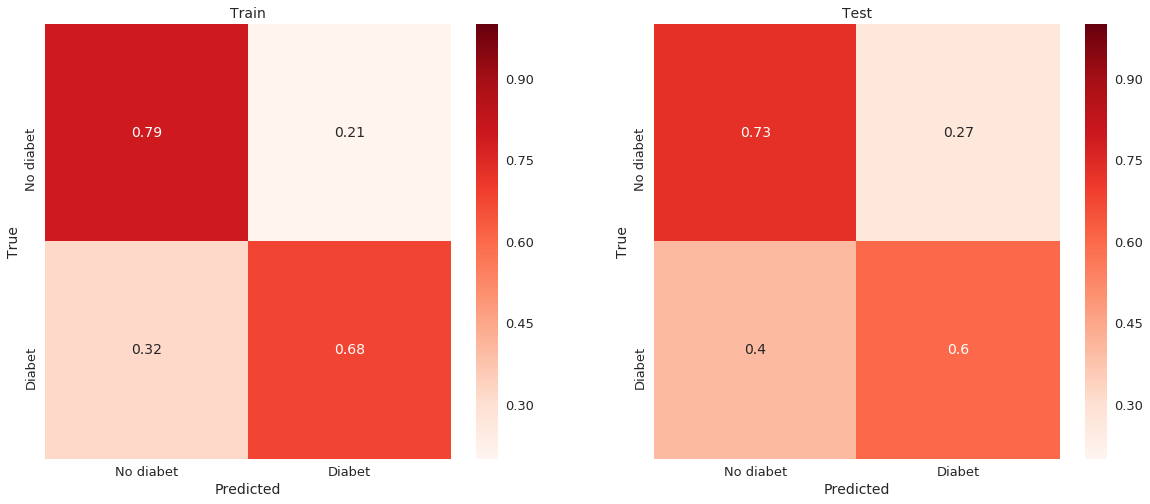

In [24]:
plt.figure(figsize=(20, 8))
class_labels = ["No diabet", "Diabet"]

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0.2, vmax=1, annot=True, annot_kws={"fontsize": 14}, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0.2, vmax=1, annot=True, annot_kws={"fontsize": 14}, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

# TASK
QUIZ: change the activation function to sigmoid for hidden layers

Comment on what you see after 200 iterations the ReLU based network versus the sigmoid-based network